In [1]:
pip install matplotlib numpy scipy --user

Note: you may need to restart the kernel to use updated packages.


Neste notebook constrói-se um modelo de sistema dinâmico acoplado simulado no domínio do tempo por integração numérica.

Esse nootebok foi disponibilizado como material complementar à FC-06 (2020-2) (https://www.youtube.com/watch?v=x8RNCyDMcwY&list=PLSarbCBaJ0dvamvwUqud_7bovWZKdMvPl&index=6).

Disciplina: ECM5336 - Controle de Sistemas Dinâmicos

Autor: Caio Dias Fernandes

Matrícula: 16204719

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint
from scipy import fftpack
import matplotlib.pylab as plab

In [3]:
def systemModel(x, t, params):
	'''
	Caso Não Linear - Considerando lift linear e drag quadrático, com ângulos não desprezíveis.
	EDO 2ª Não Linear : J*(d²θ/dt²) + C*(dθ/dt) + K*θ = (0.5*ρ*A*L*V²)*[-λ0*θ + (λ1 + λ2*θ + λ3*θ²)*sin(θ)]
    Sistema de EDOs de 1ª Ordem :
        dθ/dt = ω
        d²θ/dt² = dω/dt = (1/J)*(0.5*ρ*A*L*V²)*[-λ0*θ+(λ1+λ2*θ+λ3*θ²)*sin(θ)]-(1/J)*(C*ω + K*θ)
	'''

	# Unpacking variáveis para o sistema de EDOs:
	theta, omega = x
	(tStartAccel, tStopAccel, tEjection, tStartPertub, tStopPertub,
     pertubation, Vi, a, Ji, Jf, Li, Lf,
     K, C, rho, A, l0, l1, l2, l3) = params

	## Definindo funções para os parâmetros variáveis com t:
    
	# Ejeção de carga alterando posição do CG e momento de inércia
	if (t <= tEjection):
		L = Li
		J = Ji
	else:
		L = Lf
		J = Jf
        
	# Piloto acelrando o avião
	if (t <= tStartAccel):
		V = Vi
	elif (tStartAccel < t < tStopAccel):
		V = Vi + a*(t - tStartAccel)
	else:
		V = Vi + a*(tStopAccel - tStartAccel)
        
	# Perturbação no controle do piloto
	if (tStartPertub < t <= tStopPertub):
		theta = theta + pertubation
	
	# Sistema de EDOs:
	aux1 = 0.5*rho*A*L*V**2
	aux2 = - l0*theta + (l1+l2*theta+l3*theta**2) * np.sin(theta)
	derivs = [omega, (1/J)*(aux1*aux2 - C*omega - K*theta)]

	return derivs

In [33]:
## Simulation Time:
tStop = 15 # tempo total de voo
tInc = 0.01
tEjection = 0.5*tStop # instante de ejeção da carga alijada
tStartAccel = 0.25*tStop # instante do início da aceleração
tStopAccel = 0.75*tStop # instante do final da aceleração
tStartPertub = 0.6*tStop # instante do início da pertubação
tStopPertub = 0.61*tStop # instante do final da perturbação
t = np.arange(0., tStop, tInc)

In [34]:
## Constantes do Modelo:
rho = 1.225 # densidade do ar
A = 1 # area de referencia
l0 = 0.6 # lift coef
l1 = 0.75 # drag coef
l2 = 0.1 # drag coef
l3 = 0.05 # drag coef
C = 60 # amortecimento aerodinâmico
K = 300 # rigidez aerodinâmica

In [35]:
## Parâmetros Variáveis no Tempo:
Li = 2 # comprimento tail-boom antes da ejeção de carga
Lf = 1.2*Li # comprimento tail-boom depois da ejeção de carga
Ji = 50 # momento de inercia polar antes do alijamento de carga
Jf = 0.75*Ji # momento de inercia polar depois do alijamento de carga
Vi = 20 # velocidade inicial
a = 2 # aceleração
pertubation = 2 # magnitude da pertubação 

In [36]:
## Condições Iniciais:
theta0 = 10 # angulo de pitch
omega0 = 0 # velocidade de rotação
x0 = [theta0, omega0]

In [37]:
## Solver
params = [tStartAccel, tStopAccel, tEjection, tStartPertub, tStopPertub, pertubation, Vi, a, Ji, Jf, Li, Lf, K, C, rho, A, l0, l1, l2, l3]
sol = odeint(systemModel, x0, t, args=(params,))

In [38]:
## Preparando dados para plots auxíliares
_V=[]
_Fl=[]
_Fd=[]
_Ma=[]
_cl=[]
_cd=[]
_L=[]
_J=[]
for i in range(len(t)):
	if (t[i] <= tStartAccel):
		v = Vi
	elif (tStartAccel < t[i] <= tStopAccel):
		v = Vi + a*(t[i]-tStartAccel)
	elif (tStopAccel < t[i]):
		v = Vi + a*(tStopAccel-tStartAccel)
                
	if (t[i] <= tEjection):
		L = Li
		J = Ji
	elif (tEjection < t[i]): 
		L = Lf
		J = Jf                 
            
	cl = -l0*sol[i,0]
	cd = l1 + l2*sol[i,0] + l3*sol[i,0]**2
	Fl = 0.5*rho*A*v**2*cl
	Fd = 0.5*rho*A*v**2*cd
	Ma = Fl*L + Fd*np.sin(sol[i,0])
               
	_V.append(v)
	_Fl.append(Fl)
	_Fd.append(Fd)
	_Ma.append(Ma)
	_cl.append(cl)
	_cd.append(cd)
	_L.append(L)
	_J.append(J)    

Text(0, 0.5, 'Velocity (m/s)')

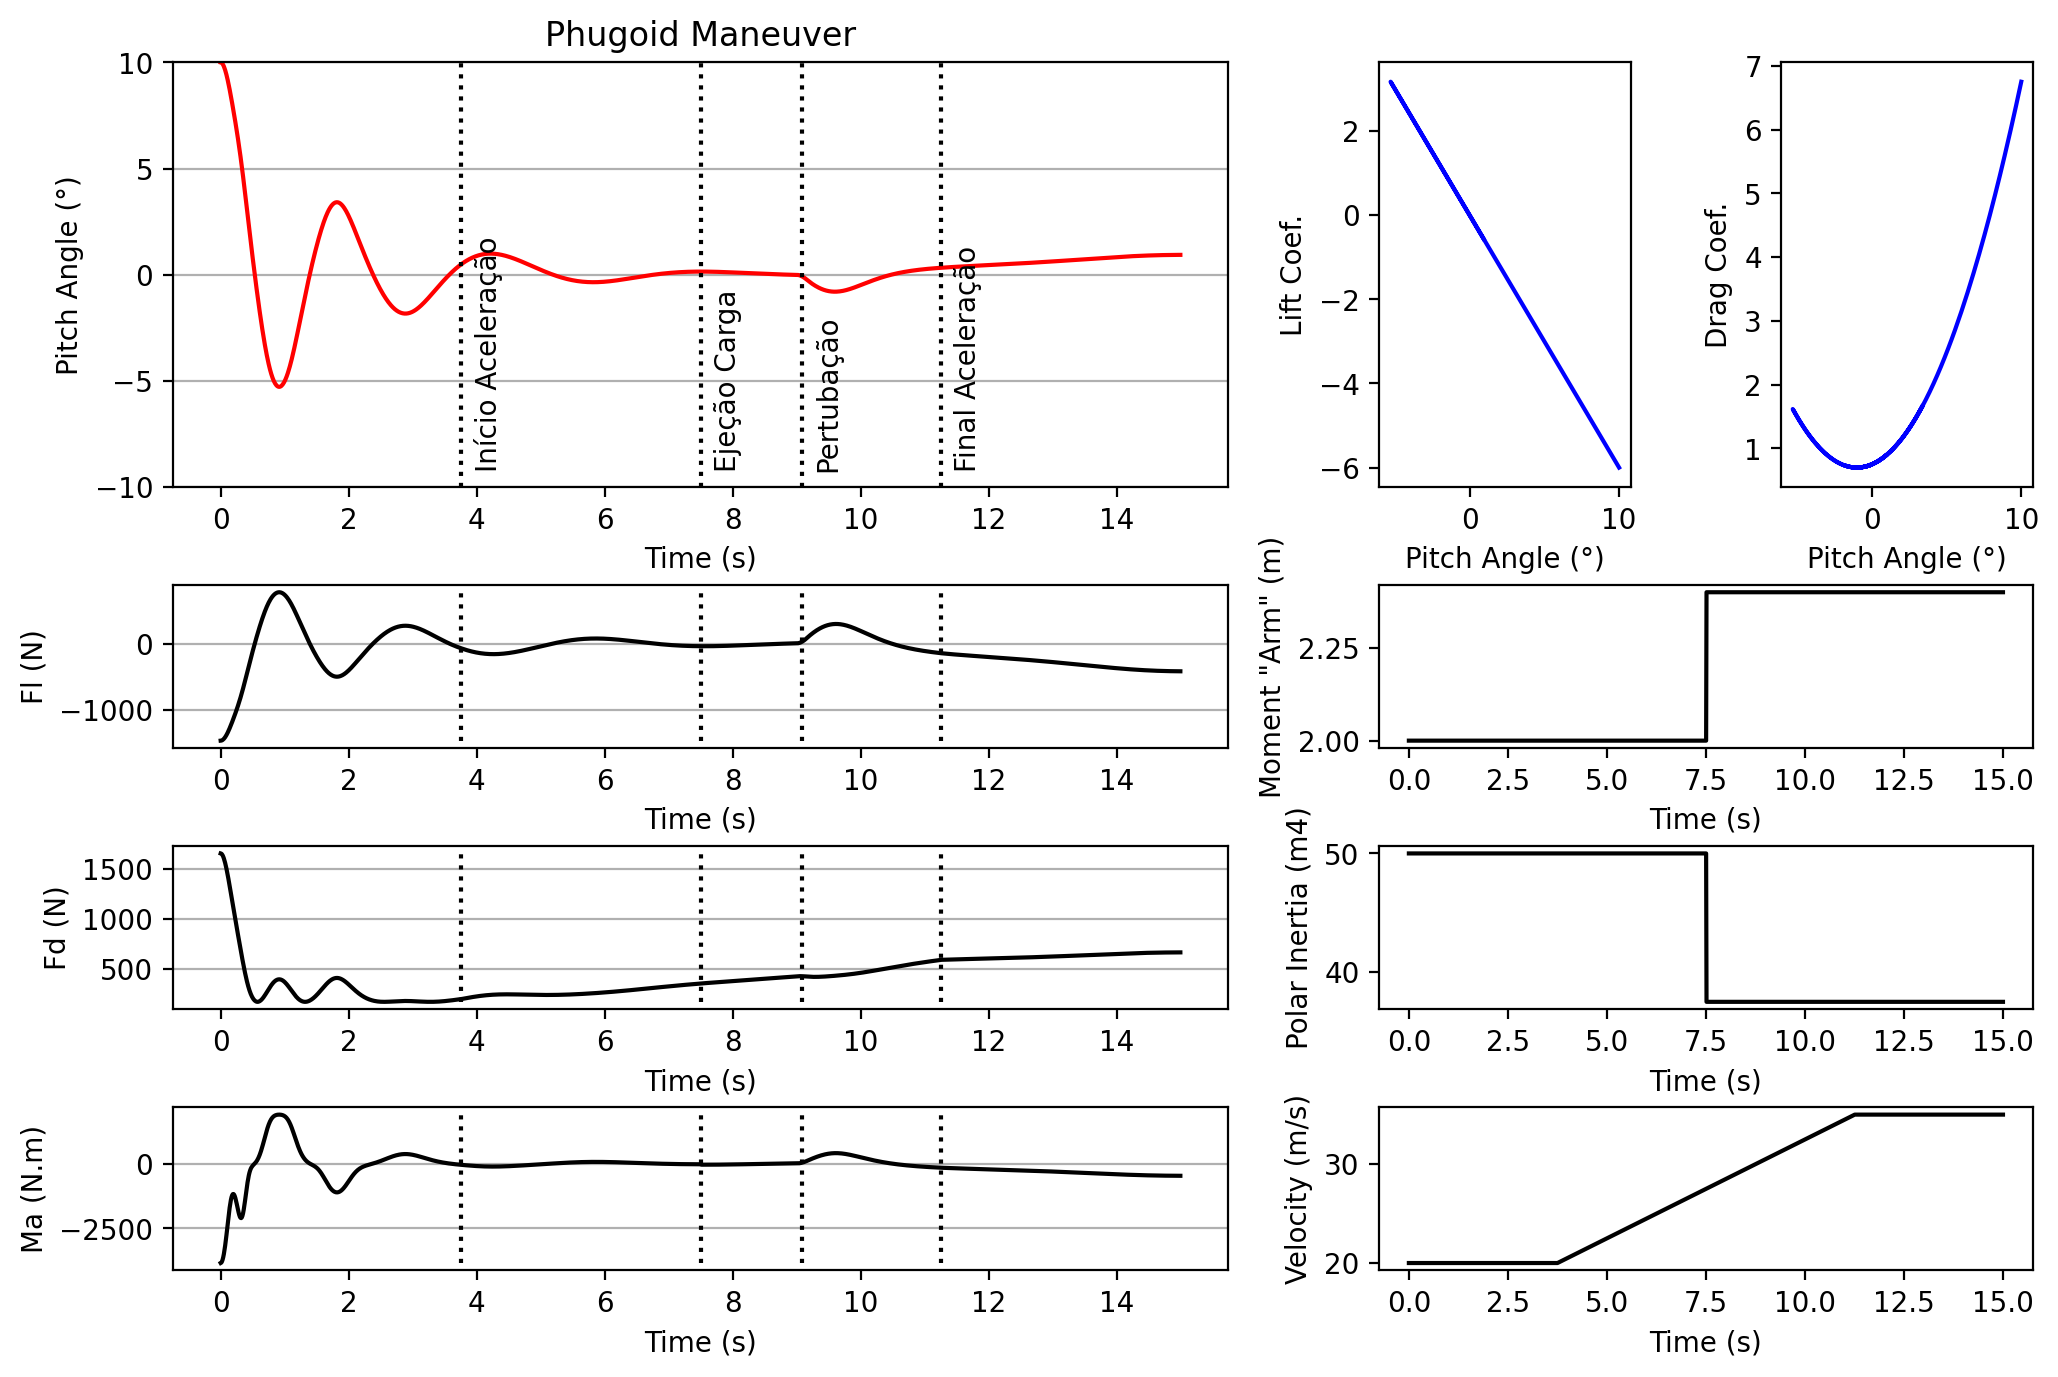

In [39]:
## Plot Fugóide + Parâmetros relevantes ao modelo

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

fig1 = plt.figure()
gs = fig1.add_gridspec(5,5, wspace=0.6, hspace=0.6)

ax0 = fig1.add_subplot(gs[:-3,:-2])
ax1 = fig1.add_subplot(gs[:-3,3])
ax2 = fig1.add_subplot(gs[:-3,4])
ax3 = fig1.add_subplot(gs[2,:-2])
ax4 = fig1.add_subplot(gs[3,:-2])
ax5 = fig1.add_subplot(gs[4,:-2])
ax6 = fig1.add_subplot(gs[2,3:])
ax7 = fig1.add_subplot(gs[3,3:])
ax8 = fig1.add_subplot(gs[4,3:])

ax0.set_title('Phugoid Maneuver')
ax0.plot(t,sol[:,0],'-r')
ax0.plot([tEjection, tEjection], [-10, 10], ':k')
ax0.plot([tStartAccel, tStartAccel], [-10, 10], ':k')
ax0.plot([tStopAccel, tStopAccel], [-10, 10], ':k')
tPertub = 0.5*(tStartPertub+tStopPertub)
ax0.plot([tPertub, tPertub], [-10, 10], ':k')
ax0.text(tEjection+0.2, -9, 'Ejeção Carga', rotation=90)
ax0.text(tStartAccel+0.2, -9, 'Início Aceleração', rotation=90)
ax0.text(tStopAccel+0.2, -9, 'Final Aceleração', rotation=90)
ax0.text(tPertub+0.2, -9, 'Pertubação', rotation=90)
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Pitch Angle (°)')
ax0.grid(axis='y')
ax0.set_ylim((-10, 10))

ax1.plot(sol[:,0],_cl,'-b')
ax1.set_xlabel('Pitch Angle (°)')
ax1.set_ylabel('Lift Coef.')

ax2.plot(sol[:,0],_cd,'-b')
ax2.set_xlabel('Pitch Angle (°)')
ax2.set_ylabel('Drag Coef.')

ax3.set_ylabel('Fl (N)')
ax3.plot(t, _Fl, '-k')
ax3.grid(axis='y')
ax3.plot([tEjection, tEjection], [np.min(_Fl), np.max(_Fl)], ':k')
ax3.plot([tStartAccel, tStartAccel], [np.min(_Fl), np.max(_Fl)], ':k')
ax3.plot([tStopAccel, tStopAccel], [np.min(_Fl), np.max(_Fl)], ':k')
ax3.plot([tPertub, tPertub], [np.min(_Fl), np.max(_Fl)], ':k')
ax3.set_xlabel('Time (s)')

ax4.set_ylabel('Fd (N)')
ax4.plot(t, _Fd, '-k')
ax4.grid(axis='y')
ax4.plot([tEjection, tEjection], [np.min(_Fd), np.max(_Fd)], ':k')
ax4.plot([tStartAccel, tStartAccel], [np.min(_Fd), np.max(_Fd)], ':k')
ax4.plot([tStopAccel, tStopAccel], [np.min(_Fd), np.max(_Fd)], ':k')
ax4.plot([tPertub, tPertub], [np.min(_Fd), np.max(_Fd)], ':k')
ax4.set_xlabel('Time (s)')

ax5.set_ylabel('Ma (N.m)')
ax5.plot(t, _Ma, '-k')
ax5.grid(axis='y')
ax5.plot([tEjection, tEjection], [np.min(_Ma), np.max(_Ma)], ':k')
ax5.plot([tStartAccel, tStartAccel], [np.min(_Ma), np.max(_Ma)], ':k')
ax5.plot([tStopAccel, tStopAccel], [np.min(_Ma), np.max(_Ma)], ':k')
ax5.plot([tPertub, tPertub], [np.min(_Ma), np.max(_Ma)], ':k')
ax5.set_xlabel('Time (s)')

ax6.plot(t, _L, '-k')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Moment "Arm" (m)')

ax7.plot(t, _J, '-k')
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Polar Inertia (m4)')

ax8.plot(t, _V, '-k')
ax8.set_xlabel('Time (s)')
ax8.set_ylabel('Velocity (m/s)')


Text(0.5, 0, 'Time (s)')

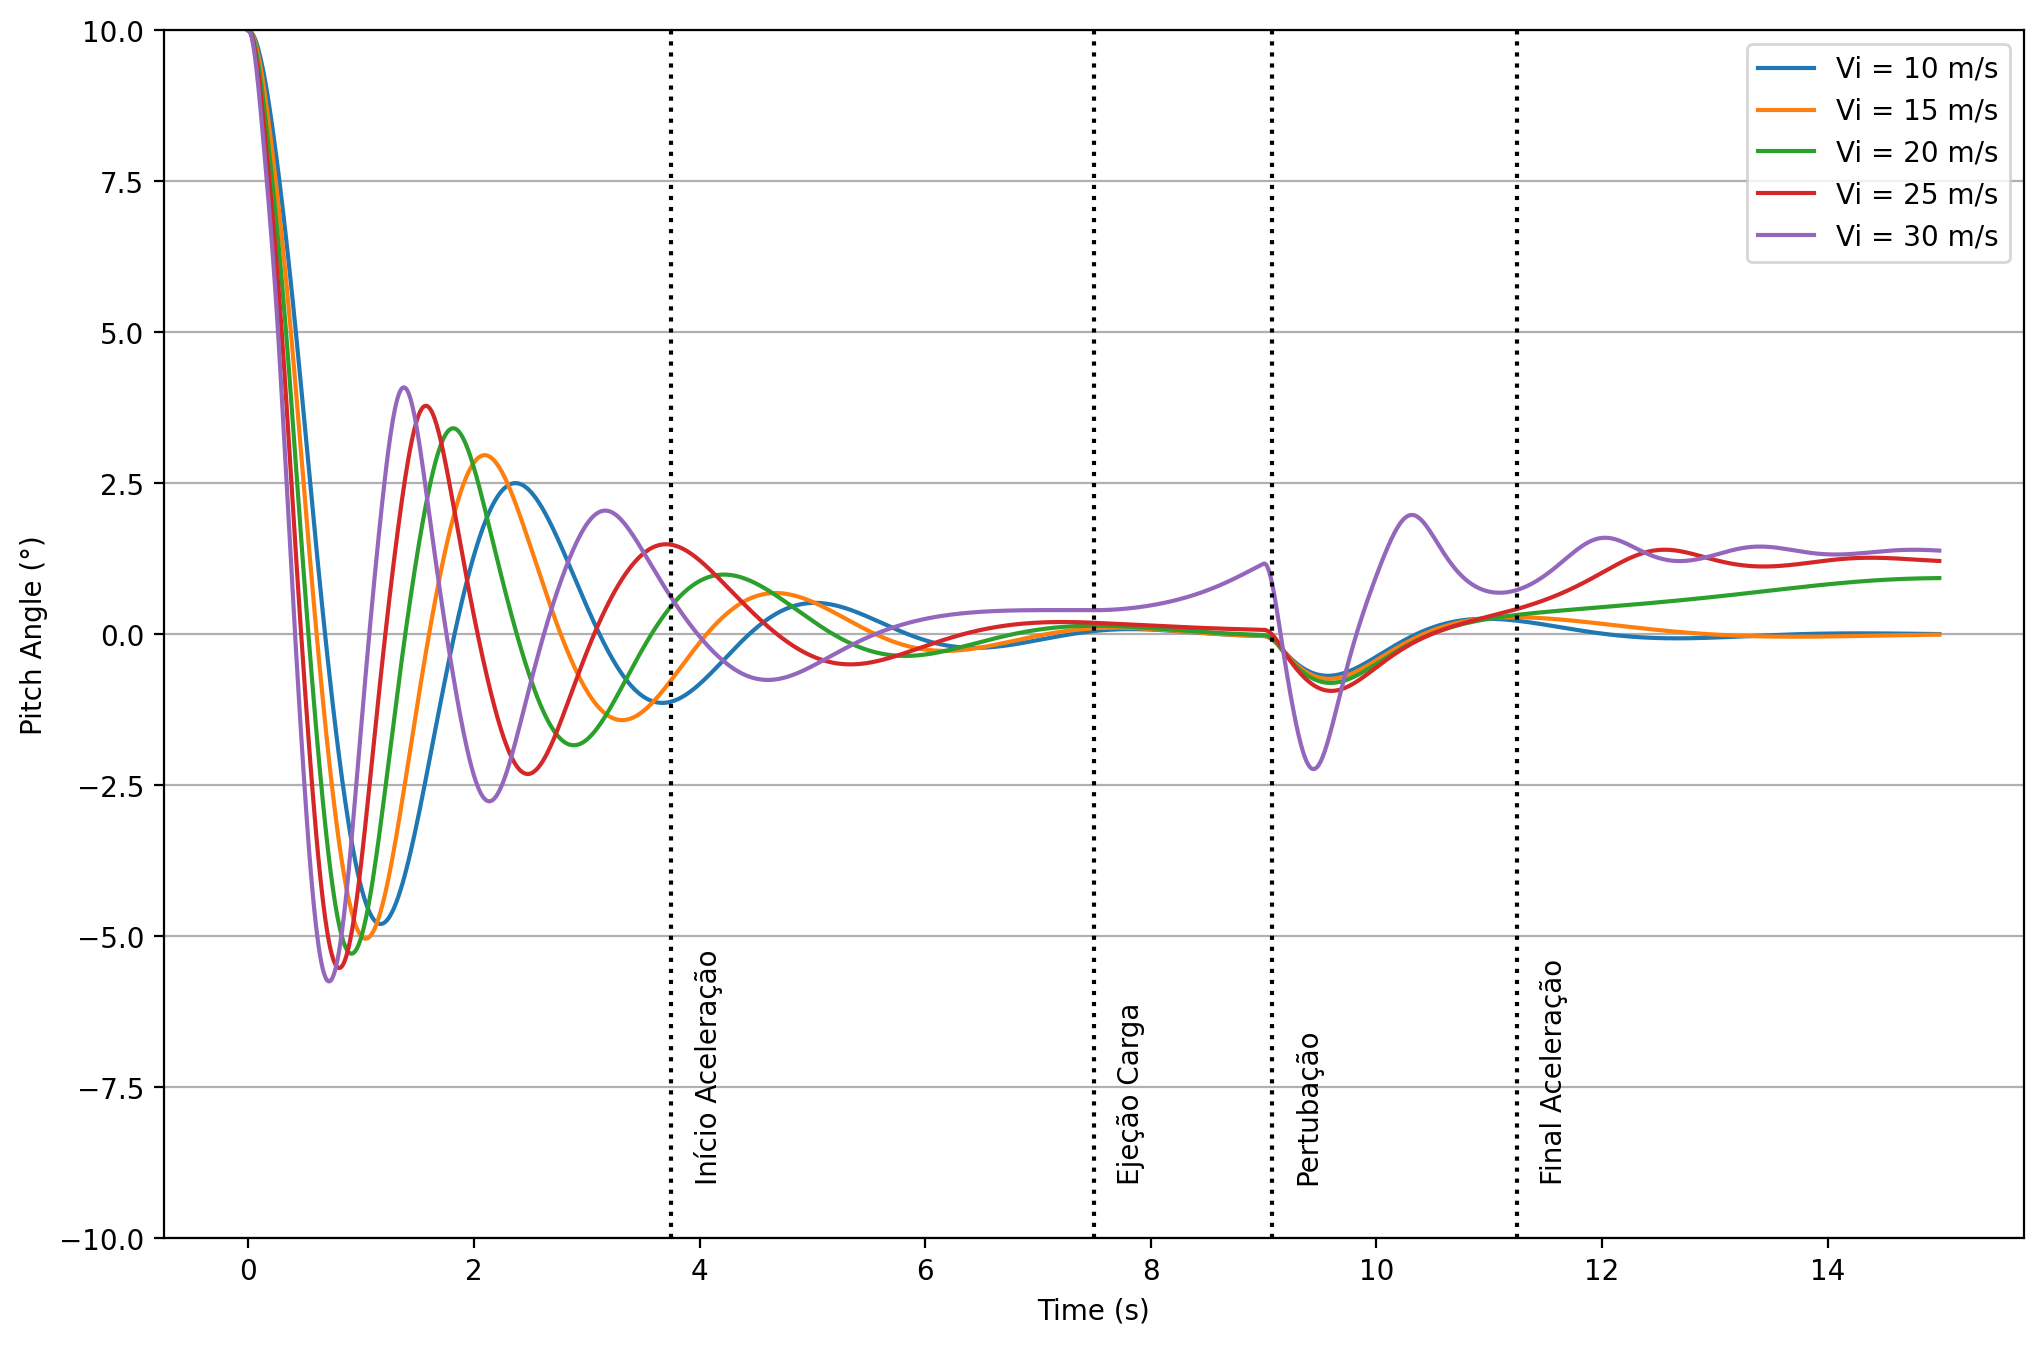

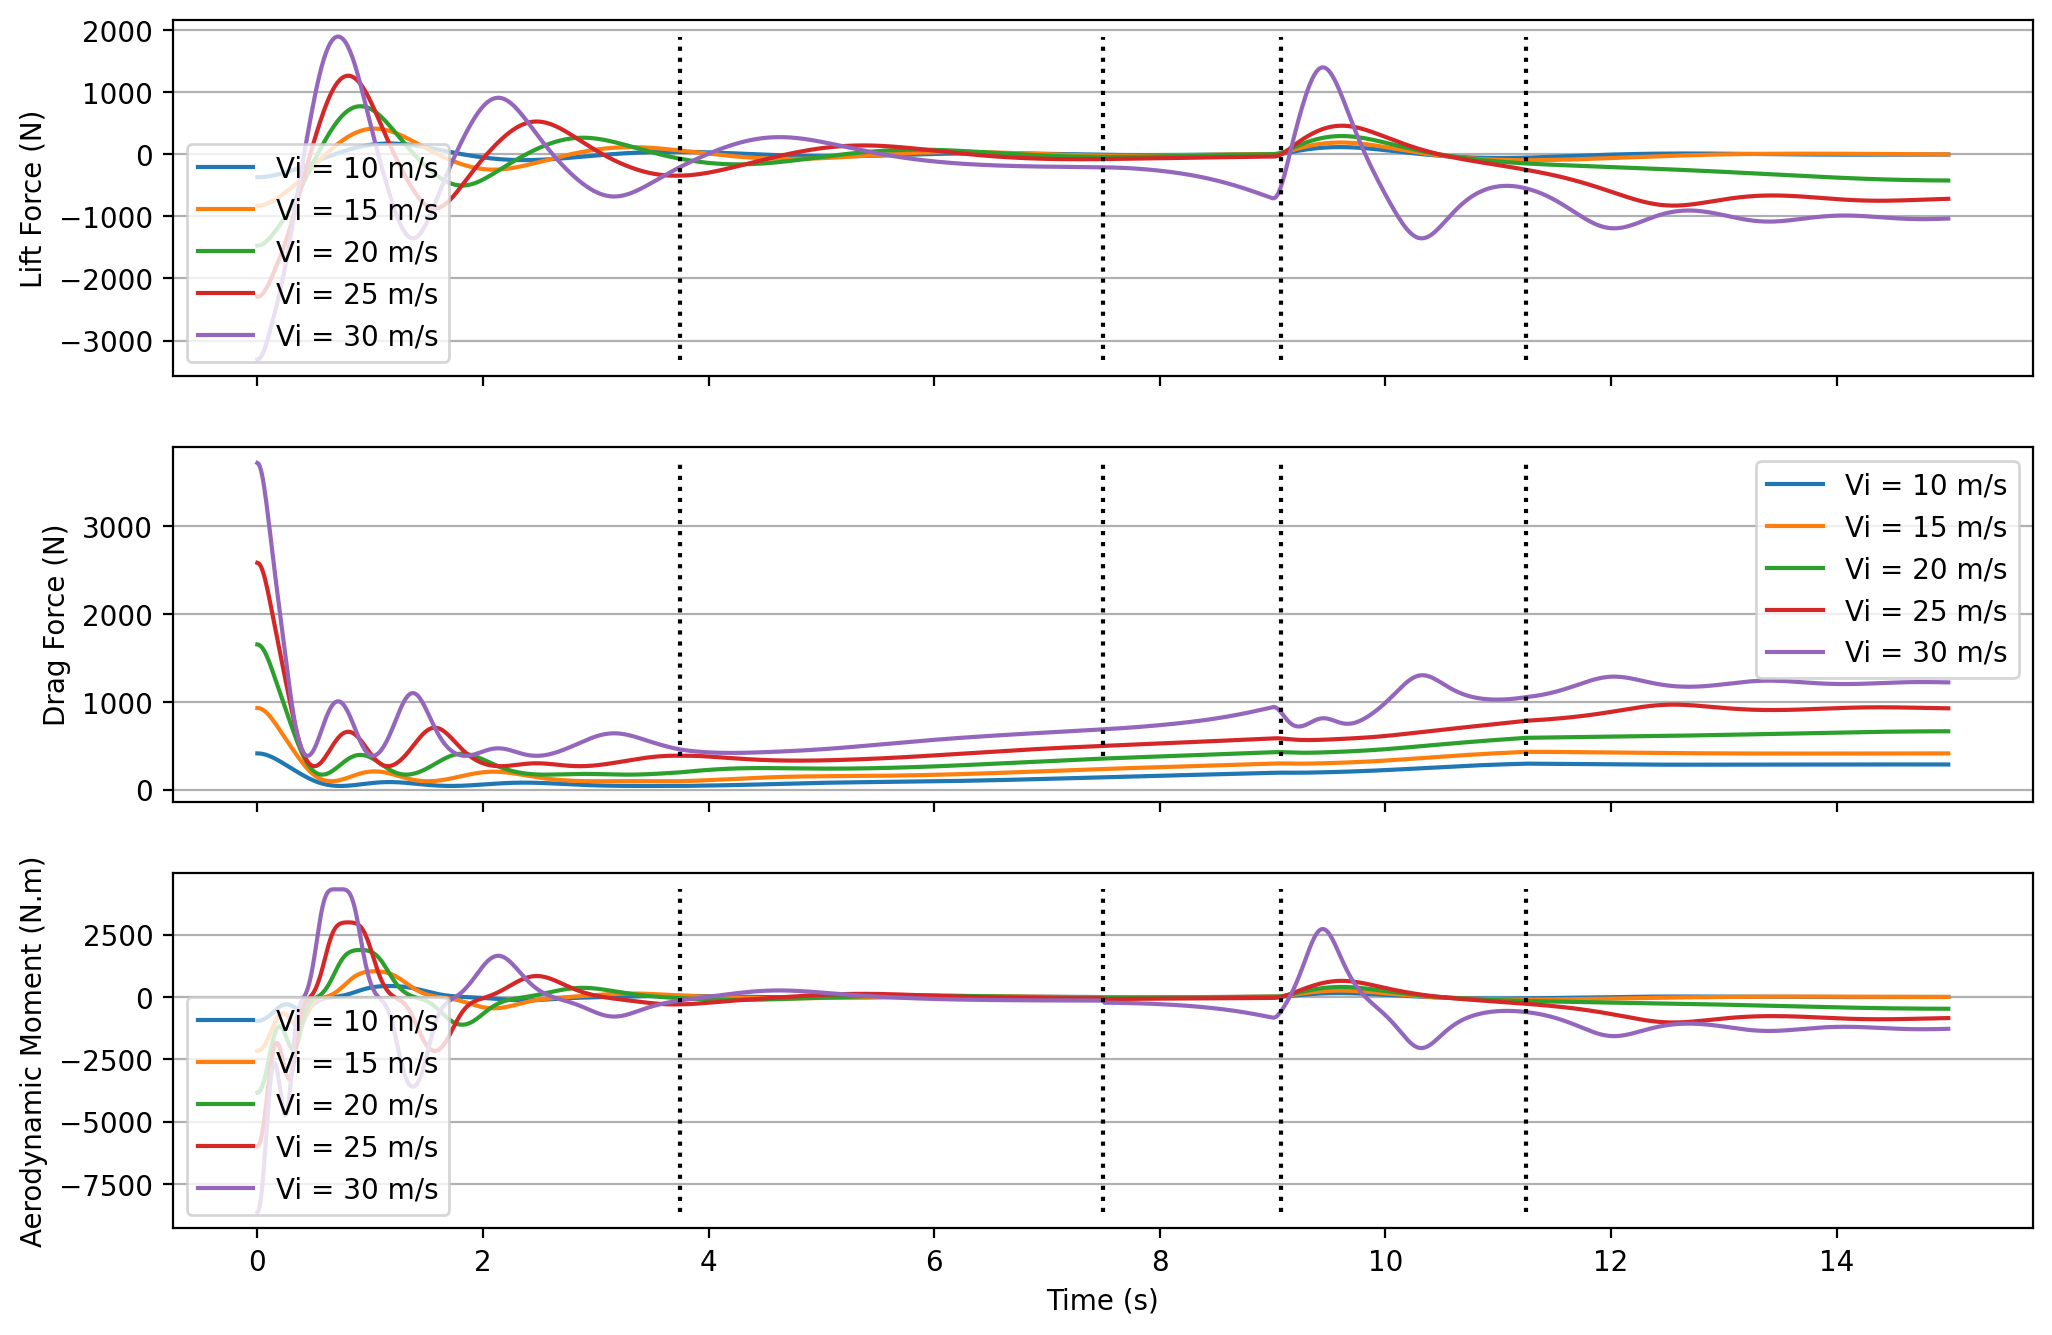

In [40]:
## Plots Fugóide E Forças Aerodinâmicas Para Várias Velocidades Inicias

## Range de velocidades iniciais para a manobra
vMin = 10
vMax = 35
vPlot = 5 # incrementos de Vi para plot

fig1, ax1 = plt.subplots()

fig2, (ax21, ax22, ax23) = plt.subplots(nrows=3, sharex=True)

colors = plab.cm.jet(np.linspace(0,1,vMax))

for Vi in np.arange(vMin,vMax,vPlot):

	params = [tStartAccel, tStopAccel, tEjection, tStartPertub, tStopPertub, pertubation, Vi, a, Ji, Jf, Li, Lf, K, C, rho, A, l0, l1, l2, l3]
    
	sol = odeint(systemModel, x0, t, args=(params,))

	#if (Vi%vPlot == 0):
	ax1.plot(t,sol[:,0], label='Vi = %s m/s'%(Vi))
	
        
	_V=[]
	_Fl=[]
	_Fd=[]
	_Ma=[]
	for i in range(len(t)):
		if (t[i] <= tStartAccel):
			v = Vi
		elif (tStartAccel < t[i] <= tStopAccel):
			v = Vi + a*(t[i]-tStartAccel)
		elif (tStopAccel < t[i]):
			v = Vi + a*(tStopAccel-tStartAccel)
                
		if (t[i] <= tEjection):
			L = Li
		elif (tEjection < t[i]): 
			L = Lf
            
		cl = -l0*sol[i,0]
		cd = l1 + l2*sol[i,0] + l3*sol[i,0]**2
		Fl = 0.5*rho*A*v**2*cl
		Fd = 0.5*rho*A*v**2*cd
		Ma = Fl*L + Fd*np.sin(sol[i,0])
            
		_V.append(v)
		_Fl.append(Fl)
		_Fd.append(Fd)
		_Ma.append(Ma)
              
	ax21.plot(t, _Fl, label='Vi = %s m/s'%(Vi))
	ax22.plot(t, _Fd, label='Vi = %s m/s'%(Vi))
	ax23.plot(t, _Ma, label='Vi = %s m/s'%(Vi))
        

ax1.plot([tEjection, tEjection], [-10, 10], ':k')
ax1.plot([tStartAccel, tStartAccel], [-10, 10], ':k')
ax1.plot([tStopAccel, tStopAccel], [-10, 10], ':k')
tPertub = 0.5*(tStartPertub+tStopPertub)
ax1.plot([tPertub, tPertub], [-10, 10], ':k')
ax1.text(tEjection+0.2, -9, 'Ejeção Carga', rotation=90)
ax1.text(tStartAccel+0.2, -9, 'Início Aceleração', rotation=90)
ax1.text(tStopAccel+0.2, -9, 'Final Aceleração', rotation=90)
ax1.text(tPertub+0.2, -9, 'Pertubação', rotation=90)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pitch Angle (°)')
ax1.legend()
ax1.grid(axis='y')
ax1.set_ylim((-10, 10))

ax21.set_ylabel('Lift Force (N)')
ax21.grid(axis='y')
ax21.plot([tEjection, tEjection], [np.min(_Fl), np.max(_Fl)], ':k')
ax21.plot([tStartAccel, tStartAccel], [np.min(_Fl), np.max(_Fl)], ':k')
ax21.plot([tStopAccel, tStopAccel], [np.min(_Fl), np.max(_Fl)], ':k')
ax21.plot([tPertub, tPertub], [np.min(_Fl), np.max(_Fl)], ':k')
ax21.legend()

ax22.set_ylabel('Drag Force (N)')
ax22.grid(axis='y')
ax22.plot([tEjection, tEjection], [np.min(_Fd), np.max(_Fd)], ':k')
ax22.plot([tStartAccel, tStartAccel], [np.min(_Fd), np.max(_Fd)], ':k')
ax22.plot([tStopAccel, tStopAccel], [np.min(_Fd), np.max(_Fd)], ':k')
ax22.plot([tPertub, tPertub], [np.min(_Fd), np.max(_Fd)], ':k')
ax22.legend()

ax23.set_ylabel('Aerodynamic Moment (N.m)')
ax23.grid(axis='y')
ax23.plot([tEjection, tEjection], [np.min(_Ma), np.max(_Ma)], ':k')
ax23.plot([tStartAccel, tStartAccel], [np.min(_Ma), np.max(_Ma)], ':k')
ax23.plot([tStopAccel, tStopAccel], [np.min(_Ma), np.max(_Ma)], ':k')
ax23.plot([tPertub, tPertub], [np.min(_Ma), np.max(_Ma)], ':k')
ax23.legend()
ax23.set_xlabel('Time (s)')
